In [89]:
import sys
sys.path.append("../../")

from scipy.interpolate import CubicSpline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from didgelab.evo.nuevolution import GeoGenome
from didgelab.calc.geo import Geo, geotools
from didgelab.util.didge_visualizer import vis_didge
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies


1


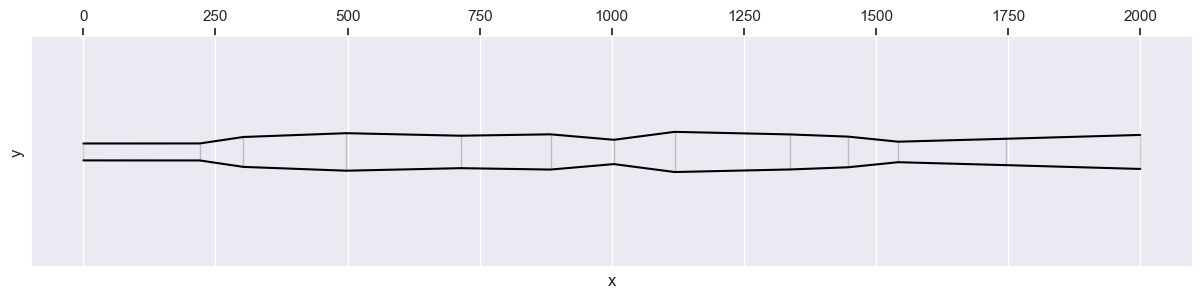

2


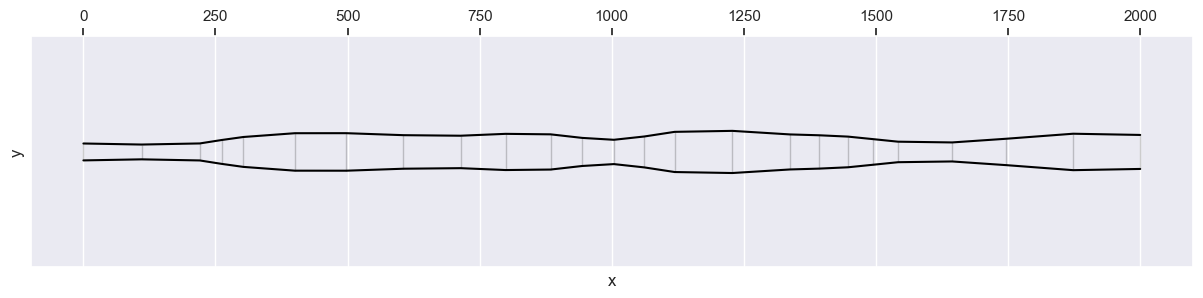

3


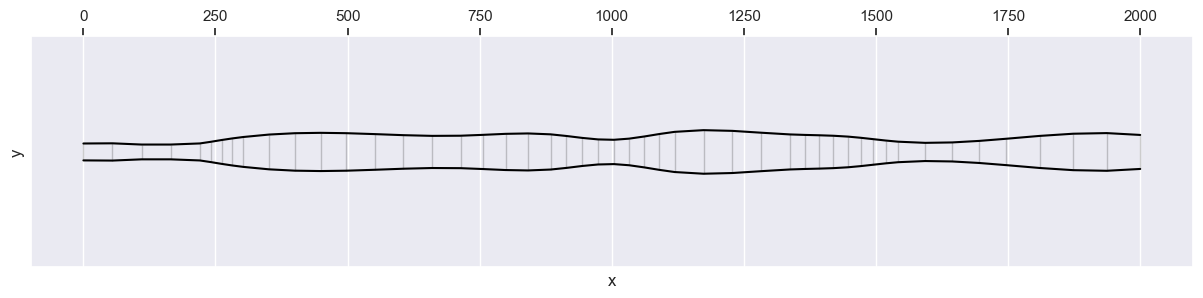

<AxesSubplot: xlabel='freq', ylabel='impedance'>

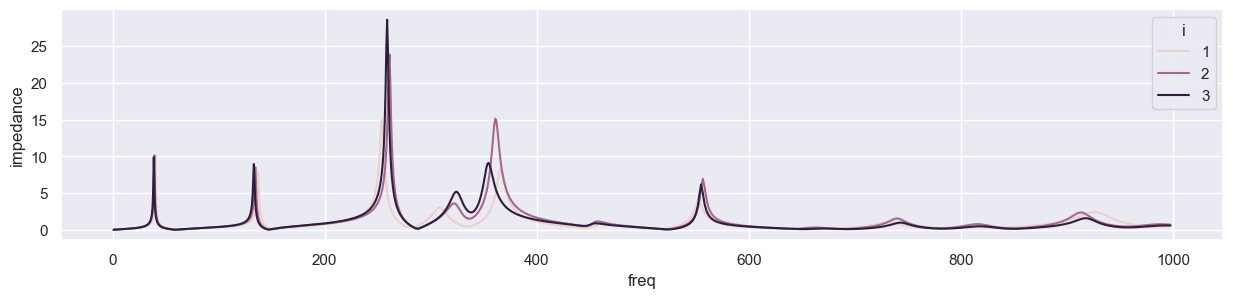

In [90]:

np.random.seed(10)


def make_shape(n=5):
    length = 2000
    d0 = 32
    dend = 80

    _x = np.random.uniform(0.3, 1.0, size=n)
    x = [0]
    for i in range(len(_x)):
        x.append(x[-1] + _x[i])

    #x = np.concatenate(([0], np.random.sample(n))) * length
    x = np.array(x)
    x = length*x/x[-1]
    y = np.random.sample(n)*(dend-d0) + d0
    y = np.concatenate(([d0], y))

    return x,y

x1,y1 = make_shape(n=12)

geo = Geo(list(zip(x1,y1)))
print(1)
vis_didge(geo)
plt.show()

freqs = get_log_simulation_frequencies(1, 1000, 5)
geo = Geo(list(zip(x1,y1)))
segments = create_segments(geo)
impedances = compute_impedance(segments, freqs)

dfs = []
df = pd.DataFrame({
    "i": [1] * len(impedances),
    "freq": freqs,
    "impedance": impedances
})
dfs.append(df)

x2=x1.copy()
y2=y1.copy()

def smooth(x1,y1):
    cs = CubicSpline(x1, y1)

    x2 = [0]
    for i in range(1, len(x1)):
        x2.append(0.5*(x1[i]+x1[i-1]))
        x2.append(x1[i])
    y2 = cs(x2)
    mind = 28
    y2[y2<mind] = mind
    return x2,y2

for i in range(2,4):
    print(i)
    x2,y2 = smooth(x2,y2)
    geo = Geo(list(zip(x2,y2)))
    vis_didge(geo)
    plt.show()

    segments = create_segments(geo)
    impedances = compute_impedance(segments, freqs)

    df = pd.DataFrame({
        "i": [i] * len(impedances),
        "freq": freqs,
        "impedance": impedances
    })
    dfs.append(df)

dfs = pd.concat(dfs)
sns.lineplot(data=dfs, x="freq", y="impedance", hue="i")



[0.33 0.2  0.62 0.3  0.27]
(5,) (5,)
(6,) (6,)


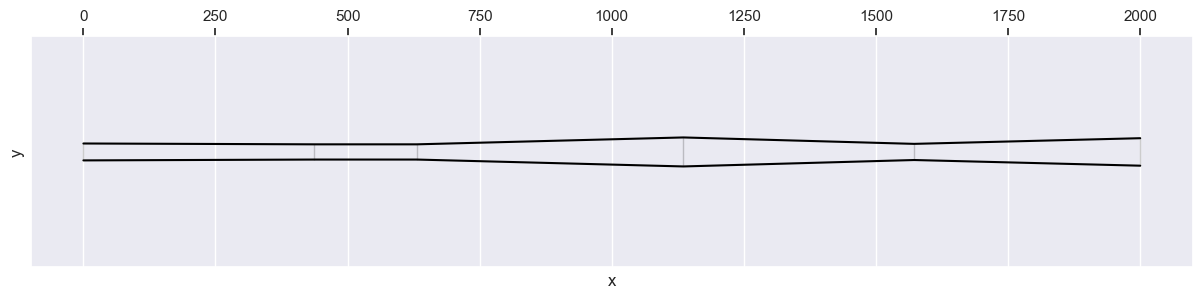

[0.52 0.47 0.46 0.46 0.56 0.62 0.49 0.3  0.18 0.27]


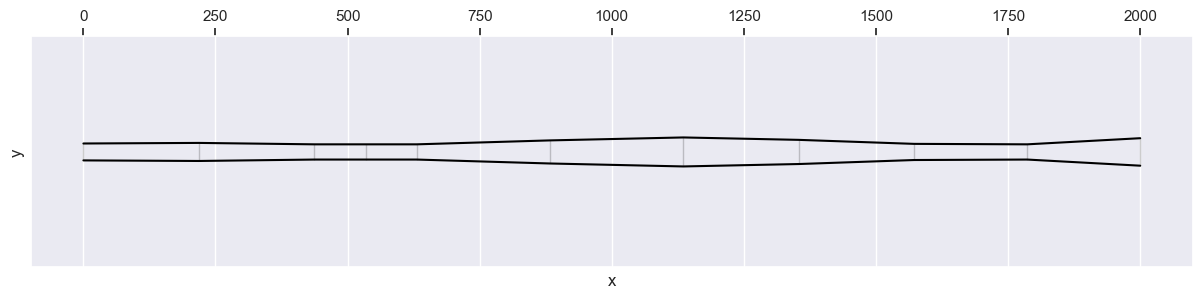

In [222]:
def smooth(x1,y1):
    cs = CubicSpline(x1, y1)

    x2 = [0]
    for i in range(1, len(x1)):
        x2.append(0.5*(x1[i]+x1[i-1]))
        x2.append(x1[i])
    y2 = cs(x2)
    #mind = 28
    #y2[y2<mind] = mind
    #print(y1)
    #print(y2)

    x2 = np.array(x2)
    return x2,y2

np.random.seed(2)

n=5
x_genome = np.random.sample(n)
y_genome = np.random.sample(n)

length = 2000
d0 = 32
bellsize = 80

power = 1.5


def basic_y_shape(n, bellsize, power, d0):
    y= np.arange(n+1)/n
    y = np.power(y, power)
    y = np.power(y, power)
    y = np.power(y, power)
    y = d0 + y*(bellsize - d0)
    return y

def make_shape(x_genome, y_genome, length, d0, bellsize, power):
    x_genome = x_genome.copy()

    x = [0]
    x_genome += 0.3
    for i in range(len(x_genome)):
        x.append(x[-1] + x_genome[i])

    x = np.array(x)    

    normalization = x[-1]
    x /= x[-1]
    x *= length

    y = y_genome.copy()
    print(y.round(2))
    y -= 0.5
    y *= 120
    y = np.concatenate(([0], y))
    y_basic = basic_y_shape(len(y)-1, bellsize, power, d0)
    y = y_basic + y
    #mind = d0*0.9
    #y[y<mind] = mind
    #maxd = bellsize
    #y[y>maxd] = maxd
    return x,y, normalization

def fix_didge(x,y, d0, bellsize):
    mind = d0*0.9
    x=x.copy()
    y=y.copy()
    y[y<mind] = mind
    maxd = bellsize
    y[y>maxd] = maxd#
    return x,y

x,y, normalization=make_shape(x_genome, y_genome, length, d0, bellsize, power)
print(x_genome.shape, y_genome.shape)
print(x.shape, y.shape)
x, y = fix_didge(x, y, d0, bellsize)
#x2.round(2) == x_genome.round(2)
geo1 = Geo(list(zip(x, y)))
vis_didge(geo1)
plt.show()

x_smooth, y_smooth = smooth(x,y)

def backward(x_smooth, y_smooth, x_genome, y_genome, normalization, length, d0, bellsize, power):
    odd = lambda x: np.array([x[i] for i in range(0, len(x), 2)])
    x_new = x_smooth/length
    x_new *= normalization

    x2 = []
    for i in range(len(x_new)-1):
        x2.append(x_new[i+1]-x_new[i])
    x_new = np.array(x2)
    x_new -= 0.3

    basic_y = basic_y_shape(len(y_smooth)-1, bellsize, power, d0)

    y_new = y_smooth - basic_y
    y_new = y_new[1:]
    y_new /= 120
    y_new += 0.5
    return x_new, y_new



x_new, y_new = backward(x_smooth, y_smooth, x_genome, y_genome, normalization, length, d0, bellsize, power)
x_new, y_new, _ = make_shape(x_new, y_new, length, d0, bellsize, power)
x_new, y_new = fix_didge(x_new, y_new, d0, bellsize)
#x2.round(2) == x_genome.round(2)
geo2 = Geo(list(zip(x_new, y_new)))
vis_didge(geo2)


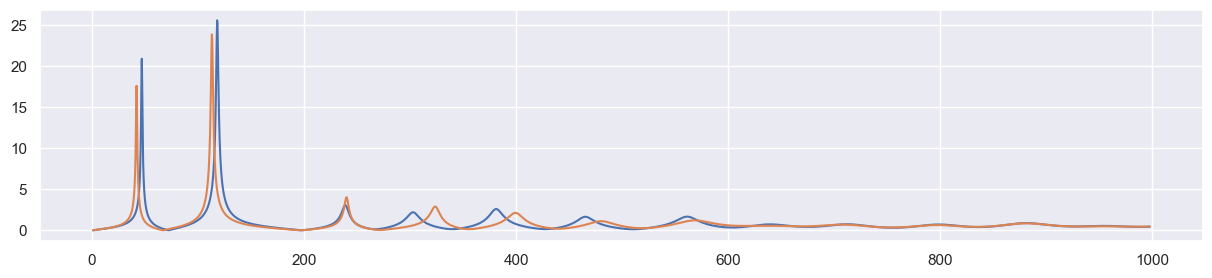

In [219]:
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo1)
impedances = compute_impedance(segments, freqs)
plt.plot(freqs, impedances)

segments = create_segments(geo2)
impedances = compute_impedance(segments, freqs)
plt.plot(freqs, impedances)

In [156]:
np.random.seed(0)

x_genome = np.random.sample(5)
x = [0]
for i in range(len(x_genome)):
    x.append(x[-1] + x_genome[i])

print(x_genome)
print(x)

x2 = []
for i in range(len(x_genome)):
    x2.append(x[i+1]-x[i])
print(x2)

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
[0, 0.5488135039273248, 1.2640028702997443, 1.8667662463713883, 2.411649429368285, 2.83530422870719]
[0.5488135039273248, 0.7151893663724196, 0.602763376071644, 0.5448831829968968, 0.4236547993389048]


In [ ]:

geo = Geo(list(zip(x,y)))
vis_didge(geo)

x2=x.copy()
y2=y.copy()

x2_genome,y2_genome = smooth(x_genome,y_genome)
x2,y2 = make_shape(x2_genome, y2_genome, n)
#x2,y2 = smooth(x2,y2)
#x2,y2 = smooth(x2,y2)
geo = Geo(list(zip(x2,y2)))
plt.show()
vis_didge(geo)